In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warehouse
import seaborn as sb


import inspect

def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]



Read Data
---

In [3]:
import os
import sys


dfs = {}

files = ["guided-ga", "guided-ga-r", "stoch-ga", "stoch-ga-r", "greedy", "cws", "tabu", "old-tabu", "tabu-heur", "optimal"]

for file_name in files:
    with open("../results/%s.results" % file_name, "r") as file:
        dfs[file_name] = warehouse.read(file.read(), type="standard")



dfs_work = {}
for file_name in files:
    with open("../results/%s_robots.results" % file_name, "r") as file:
        dfs_work[file_name] = warehouse.read(file.read(), type="work")



print(os.path.abspath(os.pardir))

/Users/jonval/WARNING/School/KeX/warehouse_cpp


Group data
---

In [5]:
grps = {}

for name, df in dfs.items():
    G = df.groupby("group")
    grps[name] = {
        "G": G,
        "g": sorted(list(G.groups.keys()))
    }


grps_work = {}
for name, df in dfs_work.items():
    G = df.groupby("group")
    grps_work[name] = {
        "G": G,
        "g": sorted(list(G.groups.keys()))
    }

    
## Work groups

print(grps.keys())
available_groups = grps["greedy"]["g"]
available_work_groups = grps_work["greedy"]["g"]

dict_keys(['guided-ga', 'guided-ga-r', 'stoch-ga', 'stoch-ga-r', 'greedy', 'cws', 'tabu', 'old-tabu', 'tabu-heur', 'optimal'])


Score Distribution
---

['0']


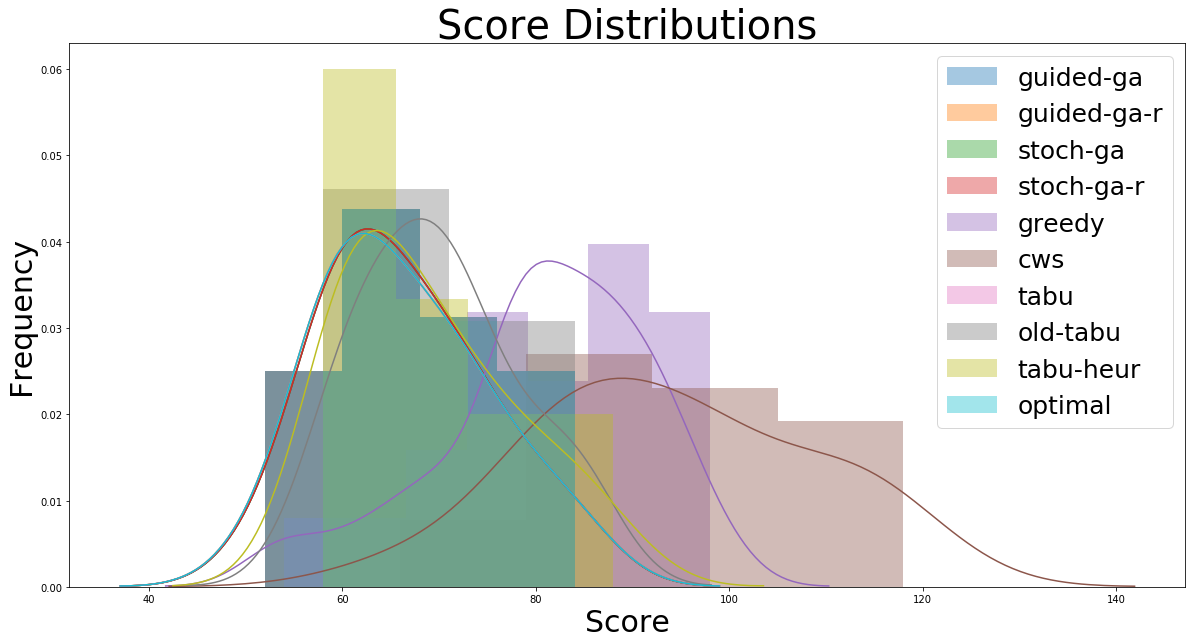

In [6]:
print(available_groups)
names = ["dist_XS", "dist_S", "dist_M", "dist_L", "dist_XL", "dist_XXL", "dist_XXXL"]
for name, i in zip(names, range(len(available_groups))):
    fig, ax = plt.subplots(1, figsize=(20, 10))

    group = i
    
    for n, grp in grps.items():
        try:
            data = grp["G"].get_group(grp["g"][i])
            sb.distplot(data["scores"], label=n)
            ax.legend(fontsize=25)
        except Exception as e:
            print("Failed to plot %s" % str(n))


    ax.set_title("Score Distributions", fontsize=40)
    ax.set_ylabel("Frequency", fontsize=30)
    ax.set_xlabel("Score", fontsize=30) 

    fig.savefig("outputs/%s.pdf" % name, bbox_inches='tight')

    plt.show()

Score Box plots
---

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


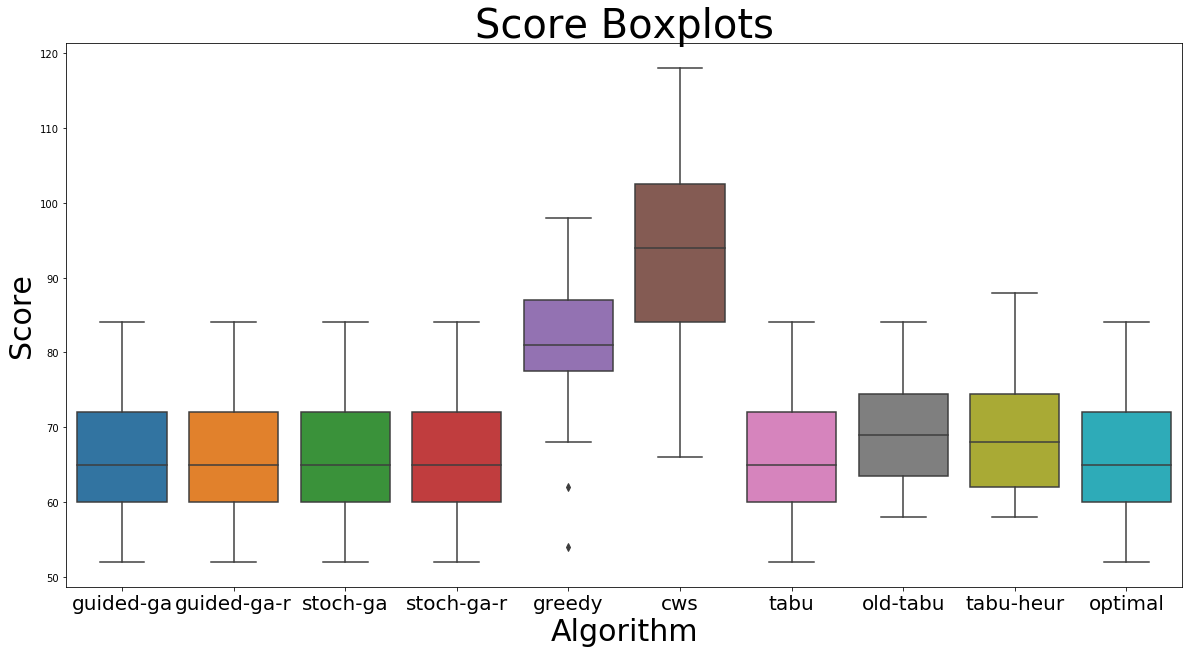

In [7]:
names = ["box_XS", "box_S", "box_M", "box_L", "box_XL", "box_XXL", "box_XXXL"]
for name, i in zip(names, range(len(available_groups))):
    fig, ax = plt.subplots(1, figsize=(20, 10))

    group = i
    
    names = []
    scores = []
    for n, grp in grps.items():
        try:
            data = grp["G"].get_group(grp["g"][i])
            names.append(n)
            scores.append(data["scores"])
        except Exception as e:
            print("Failed to plot %s" % str(n))

        
    ax.set_title("Score Boxplots", fontsize=40)
    ax.set_ylabel("Score", fontsize=30)
    ax.set_xlabel("Algorithm", fontsize=30)

    sb.boxplot(x=names, y=scores)
    ax.set_xticklabels(names, fontsize=20)


    fig.savefig("outputs/%s.pdf" % name, bbox_inches='tight')

    plt.show()

Score Distribution Development
---

In [ ]:
fig, ax = plt.subplots(1, figsize=(20, 10))

env_names = ["XS", "S", "M", "L", "XL", "XXL", "XXXL"]
for name, G in grps.items():
    G = G["G"]
    packages = []
    means = []
    stds = []
    for group in available_groups:
        try:
            g = G.get_group(group)
            packages.append(group)
            means.append(g["scores"].mean())
            stds.append(g["scores"].std())
        except Exception as e:
            print("Failed to plot group %s for %s: %s" % (str(group), name, str(e)))
    
    means = np.array(means)
    stds = np.array(stds)
    #print(len(packages))
    #print(len(means))
    sb.lineplot(packages[:len(means)], means, ax=ax, label=name)
    ax.legend(fontsize=25)
    ax.fill_between(packages[:len(means)], means + stds * 3, means - stds * 3, alpha=0.1)
    ax.set_xticklabels(env_names, fontsize=20)



ax.set_title("Score in environments", fontsize=40)
ax.set_ylabel("Score", fontsize=30)
ax.set_xlabel("Environment", fontsize=30)     
fig.savefig("outputs/dist_summary.pdf", bbox_inches='tight')

plt.show()       


Workload Distributions
---

In [ ]:
import ast

fig, ax = plt.subplots(1, figsize=(20, 10))


env_names = ["XS", "S", "M", "L", "XL", "XXL", "XXXL"]

for name, G in grps_work.items():
    G = G["G"]
    packages = []
    means = []
    stds = []
    for group in available_groups:
        try:
            g = G.get_group(group)
            packages.append(group)
            mmeans = []
            for item in g["data"]:
                arr = np.array(ast.literal_eval(item))
                mmeans.append(arr.var())
            mmeans = np.array(mmeans)
            means.append(mmeans.mean())
            stds.append(mmeans.std())
        except Exception as e:
            print("Failed to plot group %s for %s - %s" % (group, name, str(e)))
    
    means = np.array(means)
    stds = np.array(stds)
    sb.lineplot(packages, means, ax=ax, label=name)
    ax.legend(fontsize=25)
    ax.fill_between(packages, means + stds * 3, means - stds * 3, alpha=0.3)
    ax.set_xticklabels(env_names, fontsize=20)



ax.set_title("Average Variance of workload", fontsize=40)
ax.set_ylabel("Distance Traveled", fontsize=30)
ax.set_xlabel("Environment", fontsize=30)
fig.savefig("outputs/robot_workload_summary.pdf", bbox_inches='tight')

plt.show()       

Complexity Distributions
---

In [ ]:
fig, ax = plt.subplots(1, figsize=(20, 10))


env_names = ["XS", "S", "M", "L", "XL", "XXL", "XXXL"]

for name, G in grps.items():
    G = G["G"]
    packages = []
    means = []
    stds = []
    for group in available_groups:
        try:
            g = G.get_group(group)
            packages.append(group)
            
            means.append(g["computation"].mean())
            stds.append(g["computation"].std())
        except Exception as e:
            print(e)
            print("Failed to plot group %s for %s: %s" % (group, name, str(e)))
    
    means = np.array(means)
    stds = np.array(stds)
    #sb.scatterplot(packages, means, ax=ax)
    sb.lineplot(packages, means, ax=ax, label=name)
    ax.legend(fontsize=25)
    ax.fill_between(packages, means + stds * 3, means - stds * 3, alpha=0.3)
    ax.set_xticklabels(env_names, fontsize=20)



ax.set_title("Computation", fontsize=40)
ax.set_xlabel("Environment", fontsize=30)
ax.set_ylabel("Milliseconds", fontsize=30)
        
fig.savefig("outputs/algorithm_workload_summary.pdf", bbox_inches='tight')

plt.show()       
